# Prepoznavanje lica u biometrijskim sustavima

Ova bilježnica dio je Diplomskog rada na temu prepoznavanja lica u biometrijskim sustavima. 

In [ ]:
import numpy as np
import cv2
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tqdm.notebook import tqdm as tqdm_notebook
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

## 1. Učitavanje podataka

Svi javno dostupni skupovi lica mogu se pronaći na https://face-rec.org/databases/. Također, određeni skup setova slika lica moguće je dohvatiti kroz python bibloteku scikit learn (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets).

U ovom radu koristit će se dva skupa podataka:
 1. CALTECH Faces dataset <br>
    - http://www.vision.caltech.edu/html-files/archive.html
    - 450 slika, 26 jedinstvenih osoba, različiti izrazi lica, osvjetljenje, pozadine
 2. AT&T Facedatabase <br>
    - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces
    - 400 slika, 40 jedinstvenih osoba, različiti izrazi lica, osvjetljenje, različiti detalji (naočale/bez naočala), kontrolirana pozadina


### 1.1 CALTECH Faces dataset

#### 1.1.1 Preuzimanje Caltech skupa podataka

In [ ]:
!rm CalTechFaces.zip
!rm -r CalTechFaces
!wget https://dl.dropboxusercontent.com/s/m3j2xv478k1t7db/CalTechFaces.zip
!unzip CalTechFaces.zip




--2021-01-17 22:49:53--  https://dl.dropboxusercontent.com/s/m3j2xv478k1t7db/CalTechFaces.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73284544 (70M) [application/zip]
Saving to: ‘CalTechFaces.zip’

CalTechFaces.zip    100%[===================>]  69.89M  84.0MB/s    in 0.8s    

2021-01-17 22:49:54 (84.0 MB/s) - ‘CalTechFaces.zip’ saved [73284544/73284544]

Archive:  CalTechFaces.zip
   creating: CalTechFaces/
  inflating: CalTechFaces/ImageData.mat  
   creating: CalTechFaces/person_001/
  inflating: CalTechFaces/person_001/image_0001.jpg  
  inflating: CalTechFaces/person_001/image_0002.jpg  
  inflating: CalTechFaces/person_001/image_0003.jpg  
  inflating: CalTechFaces/person_001/image_0004.jpg  
  inflating: CalTechFaces/person_001/image_0005.jpg  
  inflating: C

#### 1.1.2 Učitavanje slika u strukturu podataka

In [ ]:
def read_img(imagePath):
  gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)
  return gray, imagePath.parent.name
  
# get .jpg files from all subfolders
datasetPath = Path("CalTechFaces")
imagePaths = sorted(datasetPath.glob("*/*.jpg"))

# read image and label information and store it in a dictionary
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'classes']).to_dict('list')

# check if the number of loaded images is correct, 5 images were removed from the original set
assert len(data['images']) == len(data['classes']) == 445

#### 1.1.3 Prikaz učitanih slika u izvornom obliku

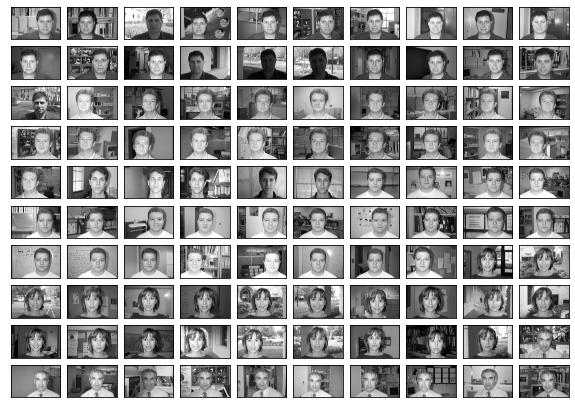

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
  ax.imshow(im, cmap = 'gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

#### 1.1.4 Detekcija lica

Za detekciju lica koristit će se Haar Cascade Face Detector (Viola i Jones) iz python biblioteke OpenCV. 

In [ ]:
!rm haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2021-01-17 22:50:08--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2021-01-17 22:50:09 (30.0 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



Nakon detekcije lica, nova slika koja prikazuje samo lice bit će veličine (47,47)

In [ ]:
face_size=(47, 47)

In [ ]:
from sklearn.datasets.base import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data = []
images = []
labels = []

for img, label in zip(data['images'], data['classes']):
  faces = faceCascade.detectMultiScale(
      img,
      scaleFactor = 1.2,
      minNeighbors = 9,
      minSize = (30, 30),
      flags = cv2.CASCADE_SCALE_IMAGE
  )

  # iterate through all faces in the image
  for (x, y, w, h) in faces:
    new_img = img.copy()
    
    # extract ROI
    raw_face = new_img[y:y+h, x:x+w]

    # resize the face to the preferred size
    face = cv2.resize(raw_face, face_size)
    face_flatten = face.flatten()
    
    images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# econde class names as integers
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

Prikaz slika nakon izvršene detekcije lica.

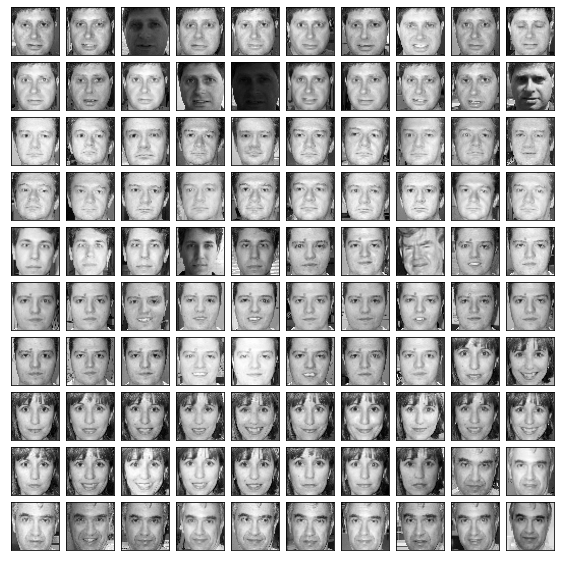

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
  ax.imshow(np.mean(im, -1), cmap = 'gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

#### 1.1.5 Kratka analiza skupa podataka

broj slika: 440
broj klasa: 26
broj značajki: 2209


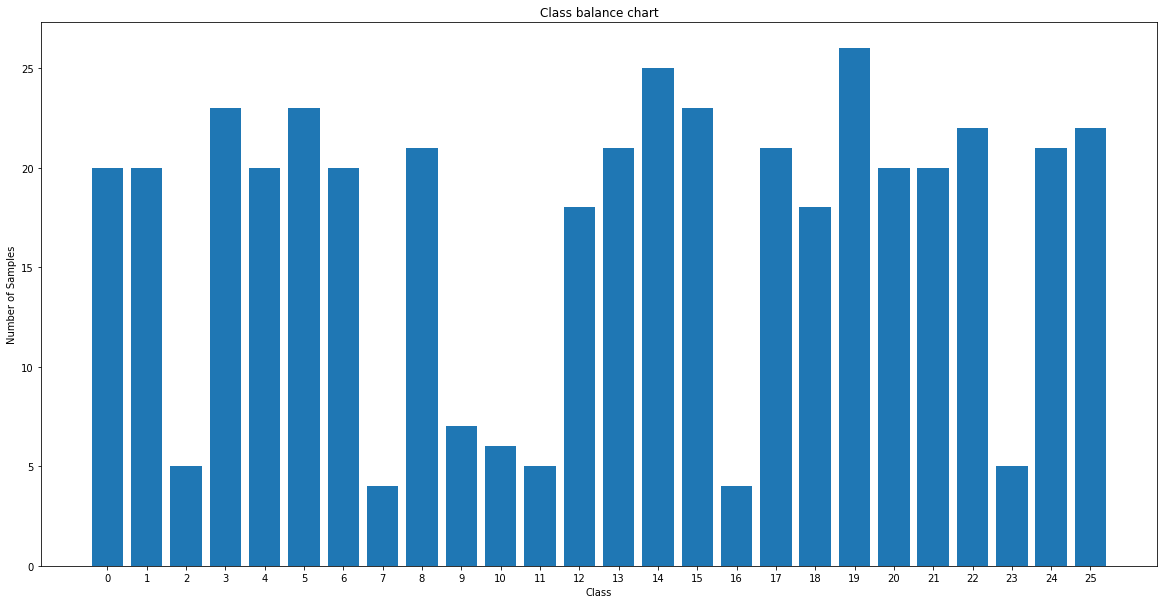

In [ ]:
from collections import Counter

n_samples, h, w, n_channels = faces.images.shape
img_shape = (h, w, n_channels)
n_classes = faces.target.max() + 1
n_features = faces.data.shape[1]

print("broj slika: %d" % n_samples)
print("broj klasa: %d" % n_classes)
print("broj značajki: %d" % n_features)

recounted = Counter(faces.target)
fig = plt.figure(figsize=(20, 10))
plt.bar(recounted.keys(), recounted.values())
plt.xticks(np.arange(n_classes))
plt.title("Class balance chart")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

## 2. Ekstrakcija značajki


Podatke je potrebno podijeliti na skup za treniranje i skup za testiranje.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=.25, shuffle = True, 
                                             stratify = faces.target, random_state = 5)

### 2.1 PCA

In [ ]:
from sklearn.decomposition import PCA

num_components = 35
num_components = min(num_components, min(n_samples, n_features))

print("broj komponenti %d" % num_components)

pca = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(x_train)

# Adjust with commented code to help choose the amount of components

# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');




broj komponenti 35


### 2.2 LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(x_train, y_train)

### 2.3 Deep Learning

Sijamska neuronska mreža - dvije konvolucijske mreže

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Lambda, Flatten, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K

import numpy.random as rng

def euclidean_distance(vectors):
  vector1, vector2 = vectors
  sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(label, ED):
  margin = 1
  # note: the images are scaled between 0 and 1
  return K.mean((1- label) * 0.5*K.square(ED) + label * 0.5* K.square(K.maximum(margin - ED, 0)))

def accuracy(y_true, y_pred):
  y_true_bool = K.cast(y_true, dtype='bool')
  return K.mean(K.equal(y_true_bool, y_pred > 0.5))

In [ ]:
def create_shared_network(input_shape):
  nb_filter = [64, 128]
  flatten_size = 128
  kernel_size = 3

  model = Sequential()
  model.add(Conv2D(filters=nb_filter[0], kernel_size=kernel_size, activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D())
  
  model.add(Conv2D(filters=nb_filter[1], kernel_size=kernel_size, activation='relu'))
  model.add(MaxPooling2D())

  model.add(Flatten())
  model.add(Dense(units=flatten_size, activation='relu'))

  return model

def create_siamese_model(input_shape):
  shared_network = create_shared_network(input_shape)
  
  input_a = Input(shape=input_shape)
  input_b = Input(shape=input_shape)
  output_a = shared_network(input_a)
  output_b = shared_network(input_b)
  
  distance = Lambda(euclidean_distance, output_shape=(1,))([output_a, output_b])

  model = Model(inputs=[input_a, input_b], outputs=distance)
  
  return shared_network, model

Za rad sijamske mreže potrebno je stvoriti parove ulaznih slika. Genuine parovi označeni su maskom 0, a Imposter parovi maskom 1. Ukupno se generira 1000 genuine parova i 1000 imposter parova.

In [ ]:
def get_siamese_paired_data(X, y, total_sample_size = 1000):
  n_samples, height, width, channels = X.shape
  n_classes = np.unique(y).shape[0]
  
  # Create a random stream of class labels 
  labels = rng.choice(n_classes,size=(2*total_sample_size,),replace=True)

  # Create arrays for genuine pairs and imposter pairs
  genuine_pairs=np.zeros((total_sample_size, 2, width, height, channels))
  imposter_pairs=np.zeros((total_sample_size, 2, width, height, channels))

  # Create a mask array to indicate which pairs are genuine (0) and which are imposter (1)
  targets=np.zeros((2*total_sample_size),)
  targets[total_sample_size:] = 1

  for i, label in enumerate(labels):
    # take the current random class label and find all indices of that label from the original y vector
    same_label_indices = np.where(y == label)[0]

    if i < total_sample_size:
      #find a random pair of indices from the same_label_indices array
      idx_1 = rng.randint(0, len(same_label_indices))
      genuine_pairs[i,0,:] = X[same_label_indices[idx_1]]
      idx_2 = rng.randint(0, len(same_label_indices))
      genuine_pairs[i,1,:] = X[same_label_indices[idx_2]] 

    else:
      # take the current random class label and find indices of all labels that are not the same as the current one
      diff_label_indices = np.where(y != label)[0]

      # find a random pair of labels where one is from same_label_incdices array, and the other from diff_label_indices array
      idx_1 = rng.randint(0, len(same_label_indices))
      imposter_pairs[i-total_sample_size,0,:] = X[same_label_indices[idx_1]]
      idx_2 = rng.randint(0, len(diff_label_indices))
      imposter_pairs[i-total_sample_size,1,:] = X[diff_label_indices[idx_2]] 

  return np.concatenate([genuine_pairs, imposter_pairs] , axis=0)/255, targets

Uz pomoć definiranih metoda moguće je stvoriti model

In [ ]:
encoder, model = create_siamese_model(img_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 47, 47, 1)]  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1713024     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[0][0]         

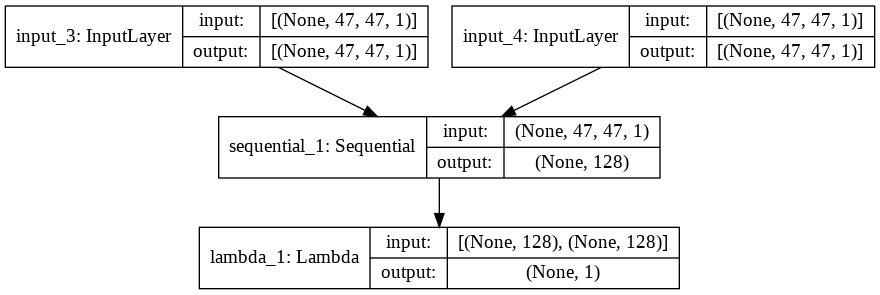

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Model je potrebno trenirati. Već mali broj epoha daje relativno dobre rezultate. Kako se model ne bi morao trenirati svaki puta sljedeći korak učitava težine koje su dobivene prethodnim treniranjem.

In [ ]:
!rm dl_siam_weights.h5
!wget https://dl.dropboxusercontent.com/s/uyvbj49afohyrq4/dl_siam_weights.h5

--2021-01-17 22:52:24--  https://dl.dropboxusercontent.com/s/uyvbj49afohyrq4/dl_siam_weights.h5
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6866800 (6.5M) [application/octet-stream]
Saving to: ‘dl_siam_weights.h5’

dl_siam_weights.h5  100%[===================>]   6.55M  37.2MB/s    in 0.2s    

2021-01-17 22:52:25 (37.2 MB/s) - ‘dl_siam_weights.h5’ saved [6866800/6866800]



In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

paired_x_train, targets_y_train = get_siamese_paired_data(np.reshape(x_train, (len(x_train), face_size[0], face_size[1], 1)), y_train)
paired_x_test, targets_y_test = get_siamese_paired_data(np.reshape(x_test, (len(x_test), face_size[0], face_size[1], 1)), y_test)

model.compile(loss=contrastive_loss, optimizer=Adam(), metrics = [accuracy])

epochs = 10

# # UNCOMMENT TO TRAIN

# history = model.fit([paired_x_train[:, 0], paired_x_train[:, 1]], targets_y_train, 
#           validation_split=0.2,
#           batch_size=32, verbose=2, epochs=epochs)

# Load weights
model.load_weights('dl_siam_weights.h5')

# # Save weights
# model.save_weights('dl_siam_weights.h5')

test_scores = model.predict([paired_x_test[:, 0], paired_x_test[:, 1]])
test_acc = accuracy_score(targets_y_test, test_scores > 0.5)

print("Točnost na setu za testiranje: %f" % test_acc)

Točnost na setu za testiranje: 0.982000


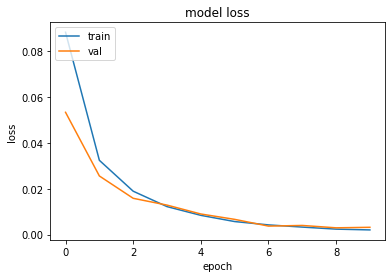

In [ ]:
# # UNCOMMENT TO PLOT MODEL LOSS DURING TRAINING

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

### 2.4 LBP

LBP implementation is taken from https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/

In [ ]:
from skimage import feature
 
class LBP:
  def __init__(self, numPoints, radius, grid_x=8, grid_y=8):
      # store the number of points and radius
      self.numPoints = numPoints
      self.radius = radius
      self.grid_x = grid_x
      self.grid_y = grid_y

  def describe(self, image, eps=1e-7):
      # compute the Local Binary Pattern representation
      # of the image, and then use the LBP representation
      # to build the histogram of patterns
      lbp = feature.local_binary_pattern(image, self.numPoints,
          self.radius, method="uniform")
      (hist, _) = np.histogram(lbp.ravel(),
          bins=np.arange(0, self.numPoints + 3),
          range=(0, self.numPoints + 2))

      # normalize the histogram
      hist = hist.astype("float")
      hist /= (hist.sum() + eps)

      # return the histogram of Local Binary Patterns
      return hist
    
  def describe_list(self, imageArray):
      lbp = []
      for image in imageArray:
          hist = self.describe_LBPH(image)
          lbp.append(hist)
      return np.array(lbp)

  def describe_LBPH(self, image, eps=1e-7):
      # calculate the LBP image
      L = feature.local_binary_pattern(image, self.numPoints,
          self.radius, method="uniform")
      # calculate the grid geometry
      lbp_height, lbp_width = L.shape
      py = int(np.floor(lbp_height/self.grid_x))
      px = int(np.floor(lbp_width/self.grid_y))

      E = []
      for row in range(0,self.grid_x):
          for col in range(0,self.grid_y):
              C = L[row*py:(row+1)*py,col*px:(col+1)*px]
              (hist, _) = np.histogram(C.ravel(), bins=np.arange(0, self.numPoints + 3), 
                                range=(0, self.numPoints + 2))
              hist = hist.astype("float")
              hist /= (hist.sum() + eps)

              E.extend(hist)
              
      return np.asarray(E)

In [ ]:
lbp = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)

### 2.5 Računanje novih značajki

Nove značajke izračunat će se i za skup za treniranje, i za skup za testiranje kako bi se mogli usporediti rezultati u oba slučaja.

In [ ]:
# Train
embedded_pca_train = pca.transform(x_train)
embedded_lda_train = lda.transform(x_train)
embedded_dl_train = encoder((np.reshape(x_train, (len(x_train), face_size[0], face_size[1], 1))).astype(float)).numpy()
embedded_lbp_train = lbp.describe_list(np.reshape(x_train, (len(x_train), face_size[0], face_size[1])))

# Test
embedded_pca_test = pca.transform(x_test)
embedded_lda_test = lda.transform(x_test)
embedded_dl_test = encoder((np.reshape(x_test, (len(x_test), face_size[0], face_size[1], 1))).astype(float)).numpy()
embedded_lbp_test = lbp.describe_list(np.reshape(x_test, (len(x_test), face_size[0], face_size[1])))


## 3. Evaluacija značajki

### 3.1 Sparivanje predložaka

Za klasifikaciju u biometrijskom sustavu potrebno je izačunati "matching score" za sve moguće parove predložaka. Također, treba naznačiti koji su rezultati "genuine", a koji "imposter".

Za izvršiti ovaj korak definirana je sljedeća funkcija.

In [ ]:
def get_pairwise_distances(embedded, labels, dist_metric):
  # get number of pairs
  l = len(embedded)
  n = np.int((l * (l - 1)) / 2)
  
  pair_index = 0
  match_scores = np.zeros(n, dtype=float)
  match_labels = np.zeros(n, dtype=int)
  
  for i in tqdm_notebook(range(l-1)):
      feature_vector1 = embedded[i]
      label1 = labels[i]

      for j in range(i + 1, l):
          feature_vector2 = embedded[j]
          label2 = labels[j]
          
          match_scores[pair_index] = dist_metric(feature_vector1, feature_vector2)

          if labels[i] == labels[j]:
              match_labels[pair_index] = 1
          pair_index += 1
  return match_scores, match_labels



U nastavku će se za mjeru udaljenosti gledati Euklidska udaljenost, tj. L2 norma.

In [ ]:
from scipy.spatial.distance import euclidean

dist_metric = euclidean

Zatim će se ova funkcija primjeniti na novo izračunate značajke za sve čeitiri vrste ekstrakcije značajki.

In [ ]:
match_scores_pca_train, match_labels_train = get_pairwise_distances(embedded_pca_train, y_train, dist_metric)
match_scores_lda_train,_ = get_pairwise_distances(embedded_lda_train, y_train, dist_metric)
match_scores_dl_train,_ = get_pairwise_distances(embedded_dl_train, y_train, dist_metric)
match_scores_lbp_train,_  = get_pairwise_distances(embedded_lbp_train, y_train, dist_metric)

match_scores_pca_test, match_labels_test = get_pairwise_distances(embedded_pca_test, y_test, dist_metric)
match_scores_lda_test,_ = get_pairwise_distances(embedded_lda_test, y_test, dist_metric)
match_scores_dl_test,_ = get_pairwise_distances(embedded_dl_test, y_test, dist_metric)
match_scores_lbp_test,_ = get_pairwise_distances(embedded_lbp_test, y_test, dist_metric)


Kako bi se metode za ekstrakciju mogle usporediti potrebno je skalirati "match score" vrijednosti.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

match_scores_pca_train = scaler.fit_transform(match_scores_pca_train.reshape(-1, 1))
match_scores_lda_train = scaler.fit_transform(match_scores_lda_train.reshape(-1, 1))
match_scores_dl_train = scaler.fit_transform(match_scores_dl_train.reshape(-1, 1))
match_scores_lbp_train = scaler.fit_transform(match_scores_lbp_train.reshape(-1, 1))

match_scores_pca_test = scaler.fit_transform(match_scores_pca_test.reshape(-1, 1))
match_scores_lda_test = scaler.fit_transform(match_scores_lda_test.reshape(-1, 1))
match_scores_dl_test = scaler.fit_transform(match_scores_dl_test.reshape(-1, 1))
match_scores_lbp_test = scaler.fit_transform(match_scores_lbp_test.reshape(-1, 1))


Prosječne vrijednosti "genuine" i "imposter" rezultata prikazane su u sljedećoj tablici

In [ ]:
def get_mean_score(match_scores, match_label, genuine):
  if genuine == 1:
    genuine_scores = [match_scores[i] for i in range(len(match_scores)) if match_label[i] == 1]
    return np.mean(genuine_scores)
  imposter_scores = [match_scores[i] for i in range(len(match_scores)) if match_label[i] == 0]
  return np.mean(imposter_scores) 

# PCA

mean_genuine_pca_train = get_mean_score(match_scores_pca_train, match_labels_train, 1)
mean_imposter_pca_train = get_mean_score(match_scores_pca_train, match_labels_train, 0)
mean_genuine_pca_test = get_mean_score(match_scores_pca_test, match_labels_test, 1)
mean_imposter_pca_test = get_mean_score(match_scores_pca_test, match_labels_test, 0)

# LDA

mean_genuine_lda_train = get_mean_score(match_scores_lda_train, match_labels_train, 1)
mean_imposter_lda_train = get_mean_score(match_scores_lda_train, match_labels_train, 0)
mean_genuine_lda_test = get_mean_score(match_scores_lda_test, match_labels_test, 1)
mean_imposter_lda_test = get_mean_score(match_scores_lda_test, match_labels_test, 0)

# DL

mean_genuine_dl_train = get_mean_score(match_scores_dl_train, match_labels_train, 1)
mean_imposter_dl_train = get_mean_score(match_scores_dl_train, match_labels_train, 0)
mean_genuine_dl_test = get_mean_score(match_scores_dl_test, match_labels_test, 1)
mean_imposter_dl_test = get_mean_score(match_scores_dl_test, match_labels_test, 0)

# LBP

mean_genuine_lbp_train = get_mean_score(match_scores_lbp_train, match_labels_train, 1)
mean_imposter_lbp_train = get_mean_score(match_scores_lbp_train, match_labels_train, 0)
mean_genuine_lbp_test = get_mean_score(match_scores_lbp_test, match_labels_test, 1)
mean_imposter_lbp_test = get_mean_score(match_scores_lbp_test, match_labels_test, 0)

print("                             |   PCA  |   LDA  |   DL   |   LBP ")
print("================================================================")
print("Mean genuine score   - TRAIN | %.4f | %.4f | %.4f | %.4f" % (mean_genuine_pca_train, mean_genuine_lda_train, mean_genuine_dl_train, mean_genuine_lbp_train))
print("Mean imposter score  - TRAIN | %.4f | %.4f | %.4f | %.4f" % (mean_imposter_pca_train, mean_imposter_lda_train, mean_imposter_dl_train, mean_imposter_lbp_train))
print("Mean genuine score   - TEST  | %.4f | %.4f | %.4f | %.4f" % (mean_genuine_pca_test, mean_genuine_lda_test, mean_genuine_dl_test, mean_genuine_lbp_test))
print("Mean imposter score  - TEST  | %.4f | %.4f | %.4f | %.4f" % (mean_imposter_pca_test, mean_imposter_lda_test, mean_imposter_dl_test, mean_imposter_lbp_test))
 

                             |   PCA  |   LDA  |   DL   |   LBP 
Mean genuine score   - TRAIN | 0.2977 | 0.1432 | 0.0599 | 0.1835
Mean imposter score  - TRAIN | 0.4244 | 0.5695 | 0.5236 | 0.3171
Mean genuine score   - TEST  | 0.3858 | 0.1649 | 0.1121 | 0.2196
Mean imposter score  - TEST  | 0.6147 | 0.5529 | 0.4908 | 0.3682


### 3.2 Distribucije rezultata sparivanja
Prije prelaska na mjere koje se koriste u verifikaciji i identifikaciji vizualizirane su distribucije "match score".

In [ ]:
n_pairs = len(match_labels_train) + len(match_labels_test)
n_genuine_scores_train = len([i for i in range(len(match_labels_train)) if match_labels_train[i] == 1])
n_imposter_scores_train = len([i for i in range(len(match_labels_train)) if match_labels_train[i] != 1])
n_genuine_scores_test = len([i for i in range(len(match_labels_test)) if match_labels_test[i] == 1])
n_imposter_scores_test = len([i for i in range(len(match_labels_test)) if match_labels_test[i] != 1])

print("                             | TRAIN |  TEST")
print("============================================")
print("Number of genuine scores     | %5d | %5d " % (n_genuine_scores_train, n_genuine_scores_test))
print("Number of imposter scores    | %5d | %5d " % (n_imposter_scores_train, n_imposter_scores_test))
print("Total                        | %5d | %5d " % (n_genuine_scores_train + n_imposter_scores_train , n_genuine_scores_test + n_imposter_scores_test))
print("============================================")

print("Total number of pairs              %5d " % (n_pairs))


                             | TRAIN |  TEST
Number of genuine scores     |  2325 |   224 
Number of imposter scores    | 51960 |  5771 
Total                        | 54285 |  5995 
Total number of pairs              60280 


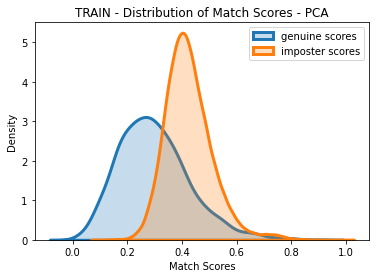

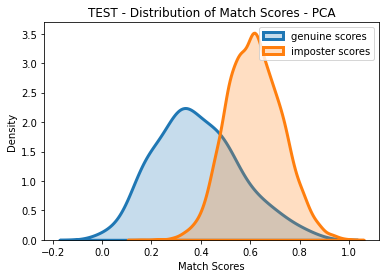

In [ ]:
genuine_scores = [match_scores_pca_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 1]
imposter_scores = [match_scores_pca_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 0]

genuine_scores2 = [match_scores_pca_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 1]
imposter_scores2 = [match_scores_pca_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 0]

ax = sns.distplot(genuine_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])
plt.xlabel('Match Scores')
plt.title('TRAIN - Distribution of Match Scores - PCA')
plt.show()

ax = sns.distplot(genuine_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])

plt.xlabel('Match Scores')
plt.title('TEST - Distribution of Match Scores - PCA')
plt.show()

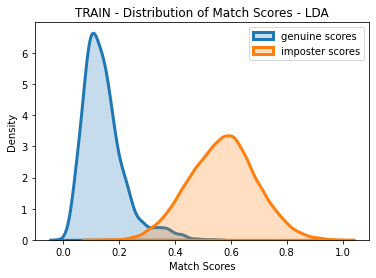

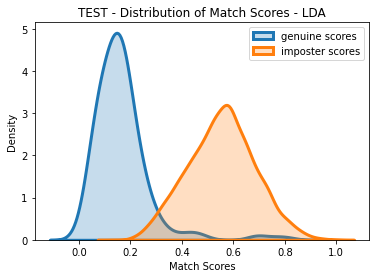

In [ ]:
genuine_scores = [match_scores_lda_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 1]
imposter_scores = [match_scores_lda_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 0]

genuine_scores2 = [match_scores_lda_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 1]
imposter_scores2 = [match_scores_lda_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 0]

ax = sns.distplot(genuine_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])
plt.xlabel('Match Scores')
plt.title('TRAIN - Distribution of Match Scores - LDA')
plt.show()

ax = sns.distplot(genuine_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])

plt.xlabel('Match Scores')
plt.title('TEST - Distribution of Match Scores - LDA')
plt.show()

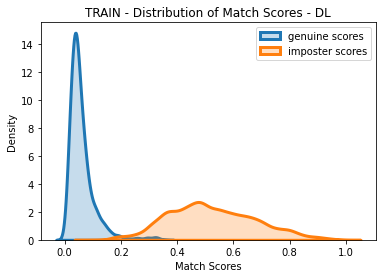

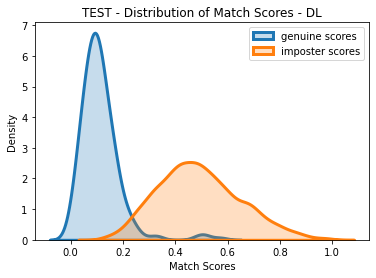

In [ ]:
genuine_scores = [match_scores_dl_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 1]
imposter_scores = [match_scores_dl_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 0]

genuine_scores2 = [match_scores_dl_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 1]
imposter_scores2 = [match_scores_dl_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 0]

ax = sns.distplot(genuine_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])
plt.xlabel('Match Scores')
plt.title('TRAIN - Distribution of Match Scores - DL')
plt.show()

ax = sns.distplot(genuine_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])

plt.xlabel('Match Scores')
plt.title('TEST - Distribution of Match Scores - DL')
plt.show()

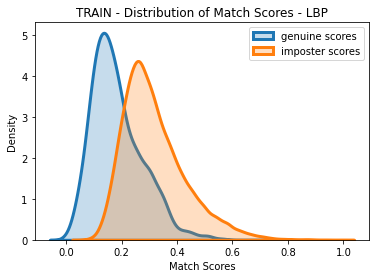

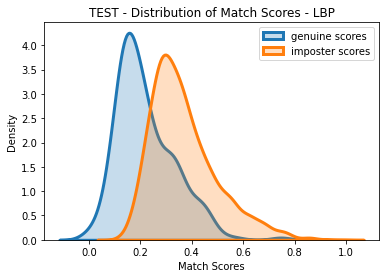

In [ ]:
genuine_scores = [match_scores_lbp_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 1]
imposter_scores = [match_scores_lbp_train[i] for i in range(len(match_labels_train)) if match_labels_train[i] == 0]

genuine_scores2 = [match_scores_lbp_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 1]
imposter_scores2 = [match_scores_lbp_test[i] for i in range(len(match_labels_test)) if match_labels_test[i] == 0]

ax = sns.distplot(genuine_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])
plt.xlabel('Match Scores')
plt.title('TRAIN - Distribution of Match Scores - LBP')
plt.show()

ax = sns.distplot(genuine_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax = sns.distplot(imposter_scores2, hist=False, kde=True, kde_kws = {'shade': True, 'linewidth': 3})
ax.legend(['genuine scores', 'imposter scores'])

plt.xlabel('Match Scores')
plt.title('TEST - Distribution of Match Scores - LBP')
plt.show()

### 3.3 Verifikacija


#### 3.3.1 Točnost i F1 mjera


Točnost i F1 mjera prikazani su kao funkcije praga odluke. Za vizualizaciju potrebno je odrediti vektor pragova odluke te izračunati vrijednosti točnosti i F1 mjeri za svaku vrijednost praga odluke.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def get_acc_f1_threshold(thresholds, match_scores, match_labels):
  accuracies = []
  f1s = []

  for thr in thresholds:
    mask = []
    for i in range(len(match_scores)):
      if match_scores[i] < thr:
        mask.append(1)
      else:
        mask.append(0)

    accuracy = accuracy_score(match_labels, mask)
    accuracies.append(accuracy)

    f1 = f1_score(match_labels, mask)
    f1s.append(f1)

  return accuracies, f1s

# Define threshold values array
thresholds = np.linspace(0,1,50)


In [ ]:
acc_pca, f1_pca = get_acc_f1_threshold(thresholds, match_scores_pca_test, match_labels_test)
acc_lda, f1_lda = get_acc_f1_threshold(thresholds, match_scores_lda_test, match_labels_test)
acc_dl, f1_dl = get_acc_f1_threshold(thresholds, match_scores_dl_test, match_labels_test)
acc_lbp, f1_lbp = get_acc_f1_threshold(thresholds, match_scores_lbp_test, match_labels_test)

best_thr_acc_pca = thresholds[acc_pca.index(np.amax(acc_pca))]
best_thr_acc_lda = thresholds[acc_lda.index(np.amax(acc_lda))]
best_thr_acc_dl = thresholds[acc_dl.index(np.amax(acc_dl))]
best_thr_acc_lbp = thresholds[acc_lbp.index(np.amax(acc_lbp))]

best_thr_f1_pca = thresholds[f1_pca.index(np.amax(f1_pca))]
best_thr_f1_lda = thresholds[f1_lda.index(np.amax(f1_lda))]
best_thr_f1_dl = thresholds[f1_dl.index(np.amax(f1_dl))]
best_thr_f1_lbp = thresholds[f1_lbp.index(np.amax(f1_lbp))]

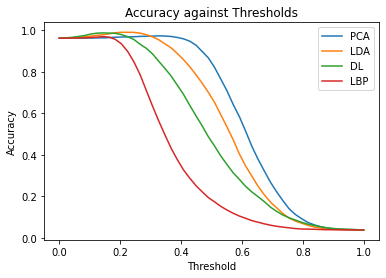

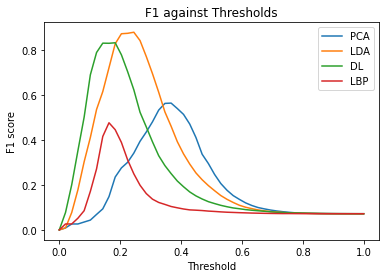

                             |   PCA  |   LDA  |   DL   |   LBP 
Optimal Accuracy Threshold   | 0.3265 | 0.2041 | 0.1429 | 0.1429
Optimal F1 Threshold         | 0.3673 | 0.2449 | 0.1837 | 0.1633


In [ ]:
plt.plot(thresholds, acc_pca)
plt.plot(thresholds, acc_lda)
plt.plot(thresholds, acc_dl)
plt.plot(thresholds, acc_lbp)
plt.legend(['PCA', 'LDA', 'DL', 'LBP'])
plt.title('Accuracy against Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

plt.plot(thresholds, f1_pca)
plt.plot(thresholds, f1_lda)
plt.plot(thresholds, f1_dl)
plt.plot(thresholds, f1_lbp)
plt.legend(['PCA', 'LDA', 'DL', 'LBP'])
plt.title('F1 against Thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 score')
plt.show()

print("                             |   PCA  |   LDA  |   DL   |   LBP ")
print("================================================================")
print("Optimal Accuracy Threshold   | %.4f | %.4f | %.4f | %.4f" % (best_thr_acc_pca, best_thr_acc_lda, best_thr_acc_dl, best_thr_acc_lbp))
print("Optimal F1 Threshold         | %.4f | %.4f | %.4f | %.4f" % (best_thr_f1_pca, best_thr_f1_lda, best_thr_f1_dl, best_thr_f1_lbp))


#### 3.3.2 DET, ROC i EER


Za prikaz ROC i DET krivulje potrebno je izračunati vrijednosti FPR i TPR, tj. FRR i FAR. Uz ovo prikazat će se i dvije agregatne mjere učinkovitosti: EER i AUC.

Prvo se definira funkcija za aproksimaciju EER

In [ ]:
def get_EER(frr, far):
  distance = far - frr
  for i in range(len(distance)):
      if distance[i] == 0:
          return (frr[i], far[i])
      if distance[i] <= 0 and distance[i+1] >= 0:
          break
  eer = (0.5*(frr[i] + frr[i+1]), 0.5*(far[i] + far[i+1]))
  return eer

Zatim se za svaku metodu ekstrakcije računaju fpr i tpr vrijednost pomoću kojih se mogu prikazati DET krivulja i ROC krivulja.

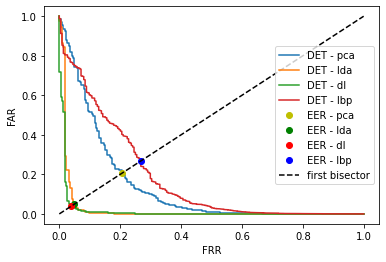

EER PCA (0.20758928571428575, 0.20585687055969504)
EER LDA (0.049107142857142905, 0.05059781666955467)
EER DL  (0.03794642857142855, 0.03950788424883036)
EER LBP (0.2678571428571429, 0.2678911800381216)


In [ ]:
from sklearn.metrics import roc_curve

fpr_pca, tpr_pca,_ = roc_curve(match_labels_test, -match_scores_pca_test)
frr_pca = 1 - tpr_pca
eer_pca = get_EER(frr_pca, fpr_pca)

fpr_lda, tpr_lda,_ = roc_curve(match_labels_test, -match_scores_lda_test)
frr_lda = 1 - tpr_lda
eer_lda = get_EER(frr_lda, fpr_lda)

fpr_dl, tpr_dl,_ = roc_curve(match_labels_test, -match_scores_dl_test)
frr_dl = 1 - tpr_dl
eer_dl = get_EER(frr_dl, fpr_dl)

fpr_lbp, tpr_lbp,_ = roc_curve(match_labels_test, -match_scores_lbp_test)
frr_lbp = 1 - tpr_lbp
eer_lbp = get_EER(frr_lbp, fpr_lbp)

bissec_x = np.linspace(0,1,100)
bissec_y = np.linspace(0,1,100)

plt.plot(frr_pca, fpr_pca)
plt.plot(frr_lda, fpr_lda)
plt.plot(frr_dl, fpr_dl)
plt.plot(frr_lbp, fpr_lbp)

plt.plot(eer_pca[0], eer_pca[1], 'yo')
plt.plot(eer_lda[0], eer_lda[1], 'go')
plt.plot(eer_dl[0], eer_dl[1], 'ro')
plt.plot(eer_lbp[0], eer_lbp[1], 'bo')

plt.plot(bissec_x,bissec_y,'k--')
plt.legend(['DET - pca', 'DET - lda', 'DET - dl', 'DET - lbp', 'EER - pca', 'EER - lda', 'EER - dl', 'EER - lbp', 'first bisector'])
plt.xlabel('FRR')
plt.ylabel('FAR')
plt.show()
print('EER PCA ' + str(eer_pca))
print('EER LDA ' + str(eer_lda))
print('EER DL  ' + str(eer_dl))
print('EER LBP ' + str(eer_lbp))


Uz ROC krivulje prikazana je i površina ispod krivulja.

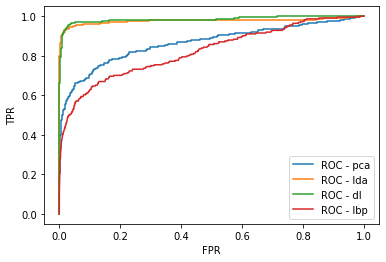

AUC_PCA = 0.8653
AUC_LDA = 0.9771
AUC_DL  = 0.9851
AUC_LBP = 0.8226


In [ ]:
from sklearn.metrics import auc

plt.plot(fpr_pca, tpr_pca)
plt.plot(fpr_lda, tpr_lda)
plt.plot(fpr_dl, tpr_dl)
plt.plot(fpr_lbp, tpr_lbp, )

plt.legend(['ROC - pca', 'ROC - lda', 'ROC - dl', 'ROC - lbp'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

pca_auc = auc(fpr_pca, tpr_pca)
lda_auc = auc(fpr_lda, tpr_lda)
dl_auc = auc(fpr_dl, tpr_dl)
lbp_auc = auc(fpr_lbp, tpr_lbp)

print('AUC_PCA = %.4f' % (pca_auc))
print('AUC_LDA = %.4f' % (lda_auc))
print('AUC_DL  = %.4f' % (dl_auc))
print('AUC_LBP = %.4f' % (lbp_auc))

#### 3.3.3 Preciznost - odziv kruvlje i prosječna preciznost


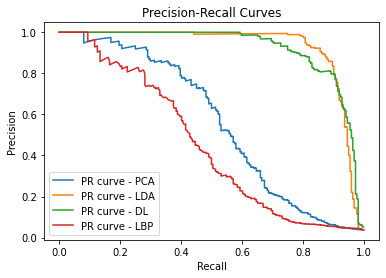

                   |   PCA  |   LDA  |   DL   |   LBP 
Area Under Curve   | 0.5605 | 0.9292 | 0.9209 | 0.4496
Average Precision  | 0.1254 | 0.1580 | 0.1974 | 0.1345


In [ ]:
from sklearn.metrics import precision_recall_curve

precision_pca, recall_pca,_ = precision_recall_curve(match_labels_test, -match_scores_pca_test)
precision_lda, recall_lda,_ = precision_recall_curve(match_labels_test, -match_scores_lda_test)
precision_dl, recall_dl,_ = precision_recall_curve(match_labels_test, -match_scores_dl_test)
precision_lbp, recall_lbp,_ = precision_recall_curve(match_labels_test, -match_scores_lbp_test)

plt.plot(recall_pca, precision_pca, label='PR curve - PCA')
plt.plot(recall_lda, precision_lda, label='PR curve - LDA')
plt.plot(recall_dl, precision_dl, label='PR curve - DL')
plt.plot(recall_lbp, precision_lbp, label='PR curve - LBP')

plt.legend()
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

PR_auc_pca = auc(recall_pca, precision_pca)
PR_auc_lda = auc(recall_lda, precision_lda)
PR_auc_dl = auc(recall_dl, precision_dl)
PR_auc_lbp = auc(recall_lbp, precision_lbp)

mean_prec_pca = np.mean(precision_pca)
mean_prec_lda = np.mean(precision_lda)
mean_prec_dl = np.mean(precision_dl)
mean_prec_lbp = np.mean(precision_lbp)


print("                   |   PCA  |   LDA  |   DL   |   LBP ")
print("======================================================")
print("Area Under Curve   | %.4f | %.4f | %.4f | %.4f" % (PR_auc_pca, PR_auc_lda, PR_auc_dl, PR_auc_lbp))
print("Average Precision  | %.4f | %.4f | %.4f | %.4f" % (mean_prec_pca, mean_prec_lda, mean_prec_dl, mean_prec_lbp))


### 3.4 Identifikacija


#### 3.4.1 CMC


Za računanje CMC potrebno je rezultate i njihove oznake prikazati u obliku matrice sličnosti.

In [ ]:
def get_sim_matrix_label(scores, n):
  sim_mat = np.zeros((n,n), dtype=float)
  index = 0
  for i in range(n):
    rem = n - (i + 1)
    sim_mat[i,i] = 1
    sim_mat[i, (i+1):] = scores[index:(index+rem)]
    sim_mat[(i+1):, i] = scores[index:(index+rem)]
    index += rem
  return sim_mat
  
def get_sim_matrix(scores, n):
  sim_mat = np.zeros((n,n), dtype=float)
  index = 0
  for i in range(n):
    rem = n - (i + 1)
    sim_mat[i,i] = 100
    sim_mat[i, (i+1):] = scores[index:(index+rem)]
    sim_mat[(i+1):, i] = scores[index:(index+rem)]
    index += rem
  return sim_mat

Potrebno je definiriati funkciju koja računa krivulju na temelju ovih matrica.

In [ ]:
def CMC(similarity_matrix, label_matrix, n_ranks):
  ranks = np.empty_like(similarity_matrix)
  for i in range(len(similarity_matrix)):
    temp = (similarity_matrix[i]).argsort()
    row_ranks = np.empty_like(temp)
    row_ranks[temp] = np.arange(len(temp))
    ranks[i] = row_ranks

  freq = np.zeros_like(ranks[0])
  for i in range(len(ranks)):
    genuine_indcs = []
    for j in range(len(label_matrix[i])):
      if label_matrix[i][j] == 1:
        genuine_indcs.append(np.int(ranks[i][j]))
    if len(genuine_indcs) != 0:
      freq[min(genuine_indcs)] += 1
  
  cmc = np.zeros(n_ranks)
  for i in range(0, n_ranks):
    if i == 0:
      cmc[i] = freq[0]
    else:
      cmc[i] = cmc[i-1] + freq[i]
      
  return cmc/len(ranks)

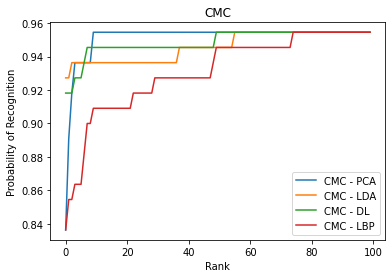

In [ ]:
n_test_samples = len(x_test)
# labels are the same for every approach
match_labels_mat = get_sim_matrix(match_labels_test,n_test_samples)

# convert into similarity matrices
match_scores_mat_pca = get_sim_matrix(match_scores_pca_test.reshape(-1),n_test_samples)
match_scores_mat_lda = get_sim_matrix(match_scores_lda_test.reshape(-1),n_test_samples)
match_scores_mat_dl = get_sim_matrix(match_scores_dl_test.reshape(-1),n_test_samples)
match_scores_mat_lbp = get_sim_matrix(match_scores_lbp_test.reshape(-1),n_test_samples)

cmc_pca = CMC(match_scores_mat_pca, match_labels_mat, 100)
cmc_lda = CMC(match_scores_mat_lda, match_labels_mat, 100)
cmc_dl = CMC(match_scores_mat_dl, match_labels_mat, 100)
cmc_lbp = CMC(match_scores_mat_lbp, match_labels_mat, 100)

plt.plot(cmc_pca)
plt.plot(cmc_lda)
plt.plot(cmc_dl)
plt.plot(cmc_lbp)

plt.title('CMC')
plt.xlabel('Rank')

plt.ylabel('Probability of Recognition')
plt.legend(['CMC - PCA', 'CMC - LDA', 'CMC - DL', 'CMC - LBP'])
plt.show()

### 3.5 Klasifikacija izvan biometrije


Klasifikacija u biometriji svodi se na usporedbu parova prema njihovoj L2 udaljenosti. O ovom dijelu, značajke će se ispitati u općenitijem slučaju višeklasne klasifikacije pomoću složenijeg klasifikatora.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

# PCA
knn.fit(embedded_pca_train, y_train)
predicted_pca = knn.predict(embedded_pca_test)
f1_micro_pca = f1_score(y_test, predicted_pca, average='micro')
f1_macro_pca = f1_score(y_test, predicted_pca, average='macro')
balanced_acc_pca = balanced_accuracy_score(y_test, predicted_pca)

# LDA
knn.fit(embedded_lda_train, y_train)
predicted_lda = knn.predict(embedded_lda_test)
f1_micro_lda = f1_score(y_test, predicted_lda, average='micro')
f1_macro_lda = f1_score(y_test, predicted_lda, average='macro')
balanced_acc_lda = balanced_accuracy_score(y_test, predicted_lda)

# DL
knn.fit(embedded_dl_train, y_train)
predicted_dl = knn.predict(embedded_dl_test)
f1_micro_dl = f1_score(y_test, predicted_dl, average='micro')
f1_macro_dl = f1_score(y_test, predicted_dl, average='macro')
balanced_acc_dl = balanced_accuracy_score(y_test, predicted_dl)

# LBP
knn.fit(embedded_lbp_train, y_train)
predicted_lbp = knn.predict(embedded_lbp_test)
f1_micro_lbp = f1_score(y_test, predicted_lbp, average='micro')
f1_macro_lbp = f1_score(y_test, predicted_lbp, average='macro')
balanced_acc_lbp = balanced_accuracy_score(y_test, predicted_lbp)


print("                        |   PCA  |   LDA  |   DL   |   LBP ")
print("===========================================================")
print("F1 score Micro-Average  | %.4f | %.4f | %.4f | %.4f" % (f1_micro_pca, f1_micro_lda, f1_micro_dl, f1_micro_lbp))
print("F1 score Macro-Average  | %.4f | %.4f | %.4f | %.4f" % (f1_macro_pca, f1_macro_lda, f1_macro_dl, f1_macro_lbp))
print("Balanced Accuracy       | %.4f | %.4f | %.4f | %.4f" % (balanced_acc_pca, balanced_acc_lda, balanced_acc_dl, balanced_acc_lda))



print()
print("Classification Report - DL embeddings")
print()
target_names = [str(x) for x in np.unique(faces.target)]
print(classification_report(y_test, predicted_dl, target_names=target_names))

                        |   PCA  |   LDA  |   DL   |   LBP 
F1 score Micro-Average  | 0.9000 | 0.9455 | 0.9636 | 0.8636
F1 score Macro-Average  | 0.8198 | 0.8846 | 0.9627 | 0.7565
Balanced Accuracy       | 0.8288 | 0.8958 | 0.9590 | 0.8958

Classification Report - DL embeddings

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         2
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         1
          12     